In [2]:
%matplotlib inline


# Scaling the regularization parameter for SVCs


The following example illustrates the effect of scaling the
regularization parameter when using `svm` for
`classification <svm_classification>`.
For SVC classification, we are interested in a risk minimization for the
equation:


\begin{align}C \sum_{i=1, n} \mathcal{L} (f(x_i), y_i) + \Omega (w)\end{align}

where

    - $C$ is used to set the amount of regularization
    - $\mathcal{L}$ is a `loss` function of our samples
      and our model parameters.
    - $\Omega$ is a `penalty` function of our model parameters

If we consider the loss function to be the individual error per
sample, then the data-fit term, or the sum of the error for each sample, will
increase as we add more samples. The penalization term, however, will not
increase.

When using, for example, `cross validation <cross_validation>`, to
set the amount of regularization with `C`, there will be a
different amount of samples between the main problem and the smaller problems
within the folds of the cross validation.

Since our loss function is dependent on the amount of samples, the latter
will influence the selected value of `C`.
The question that arises is `How do we optimally adjust C to
account for the different amount of training samples?`

The figures below are used to illustrate the effect of scaling our
`C` to compensate for the change in the number of samples, in the
case of using an `l1` penalty, as well as the `l2` penalty.

l1-penalty case
-----------------
In the `l1` case, theory says that prediction consistency
(i.e. that under given hypothesis, the estimator
learned predicts as well as a model knowing the true distribution)
is not possible because of the bias of the `l1`. It does say, however,
that model consistency, in terms of finding the right set of non-zero
parameters as well as their signs, can be achieved by scaling
`C1`.

l2-penalty case
-----------------
The theory says that in order to achieve prediction consistency, the
penalty parameter should be kept constant
as the number of samples grow.

Simulations
------------

The two figures below plot the values of `C` on the `x-axis` and the
corresponding cross-validation scores on the `y-axis`, for several different
fractions of a generated data-set.

In the `l1` penalty case, the cross-validation-error correlates best with
the test-error, when scaling our `C` with the number of samples, `n`,
which can be seen in the first figure.

For the `l2` penalty case, the best result comes from the case where `C`
is not scaled.

.. topic:: Note:

    Two separate datasets are used for the two different plots. The reason
    behind this is the `l1` case works better on sparse data, while `l2`
    is better suited to the non-sparse case.

--  

**NOTE:** This is sourced from ```scikit-learn``` learning module found here:   
https://scikit-learn.org/stable/auto_examples/svm/plot_svm_scale_c.html#sphx-glr-auto-examples-svm-plot-svm-scale-c-py

--

Automatically created module for IPython interactive environment


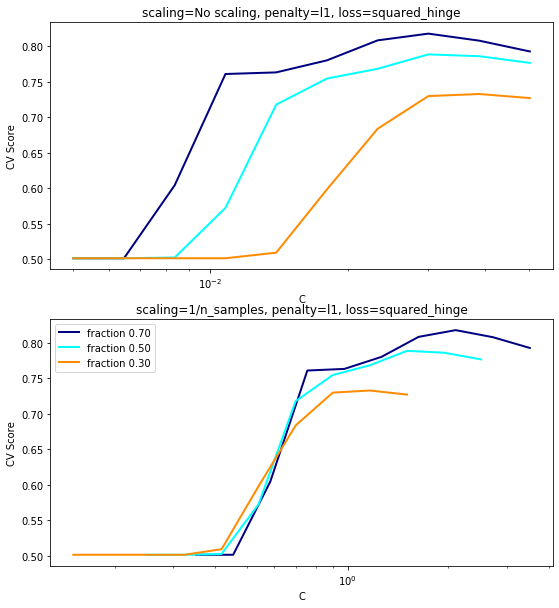

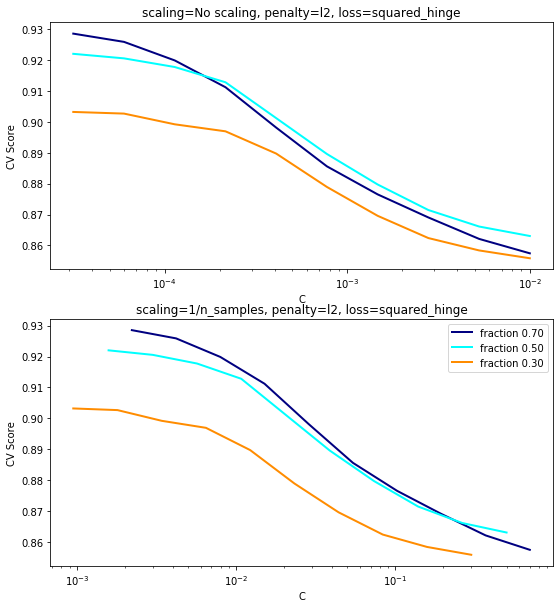

In [3]:
print(__doc__)


# Author: Andreas Mueller <amueller@ais.uni-bonn.de>
#         Jaques Grobler <jaques.grobler@inria.fr>
# License: BSD 3 clause


import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.utils import check_random_state
from sklearn import datasets

rnd = check_random_state(1)

# set up dataset
n_samples = 100
n_features = 300

# l1 data (only 5 informative features)
X_1, y_1 = datasets.make_classification(n_samples=n_samples,
                                        n_features=n_features, n_informative=5,
                                        random_state=1)

# l2 data: non sparse, but less features
y_2 = np.sign(.5 - rnd.rand(n_samples))
X_2 = rnd.randn(n_samples, n_features // 5) + y_2[:, np.newaxis]
X_2 += 5 * rnd.randn(n_samples, n_features // 5)

clf_sets = [(LinearSVC(penalty='l1', loss='squared_hinge', dual=False,
                       tol=1e-3),
             np.logspace(-2.3, -1.3, 10), X_1, y_1),
            (LinearSVC(penalty='l2', loss='squared_hinge', dual=True,
                       tol=1e-4),
             np.logspace(-4.5, -2, 10), X_2, y_2)]

colors = ['navy', 'cyan', 'darkorange']
lw = 2

for clf, cs, X, y in clf_sets:
    # set up the plot for each regressor
    fig, axes = plt.subplots(nrows=2, sharey=True, figsize=(9, 10))

    for k, train_size in enumerate(np.linspace(0.3, 0.7, 3)[::-1]):
        param_grid = dict(C=cs)
        # To get nice curve, we need a large number of iterations to
        # reduce the variance
        grid = GridSearchCV(clf, refit=False, param_grid=param_grid,
                            cv=ShuffleSplit(train_size=train_size,
                                            test_size=.3,
                                            n_splits=250, random_state=1))
        grid.fit(X, y)
        scores = grid.cv_results_['mean_test_score']

        scales = [(1, 'No scaling'),
                  ((n_samples * train_size), '1/n_samples'),
                  ]

        for ax, (scaler, name) in zip(axes, scales):
            ax.set_xlabel('C')
            ax.set_ylabel('CV Score')
            grid_cs = cs * float(scaler)  # scale the C's
            ax.semilogx(grid_cs, scores, label="fraction %.2f" %
                        train_size, color=colors[k], lw=lw)
            ax.set_title('scaling=%s, penalty=%s, loss=%s' %
                         (name, clf.penalty, clf.loss))

    plt.legend(loc="best")
plt.show()